# Finding ODE solutions

PyGOM allows the user to evaluate both the **deterministic** and **stochastic** time evolution of their ODE system using the class methods {func}`solve_determ` and {func}`solve_stochast` respectively.
These methods work with both fixed and random parameters as introduced in the {doc}`previous section <../notebooks/model_params>`.

We begin by defining the series of ODEs and parameters which define our SIR system.
This we do from scratch rather than loading in a previously defined model in order to present a more comprehensive example of the workflow.

In [1]:
from pygom import SimulateOde, Transition, TransitionType
import matplotlib.pyplot as plt
import numpy as np
import random

###################
# ODE specification
###################

# Define SIR model
stateList = ['S', 'I', 'R']
paramList = ['beta', 'gamma', 'N']
transitionList = [Transition(origin='S', destination='I', equation='beta*S*I/N', transition_type=TransitionType.T),
                  Transition(origin='I', destination='R', equation='gamma*I', transition_type=TransitionType.T)]

n_pop=1e4  # Total population is fixed

############
# Parameters
############

beta_mn=0.35   # Infectivity, beta. Gives the actual value for fixed params and mean for random distribution.
gamma_mn=0.25  # Recovery rate, gamma.

#######
# Fixed
#######
fixed_param_set=[('beta', beta_mn), ('gamma', gamma_mn), ('N', n_pop)]

########
# Random
########

# Recovery rate, gamma
gamma_var=(gamma_mn/10)**2  # Set the standard deviation to be 1/10th of the mean value
gamma_shape=(gamma_mn**2)/gamma_var
gamma_rate=gamma_mn/gamma_var

# Infectivity parameter, beta
beta_var=(beta_mn/10)**2  # Set the standard deviation to be 1/10th of the mean value
beta_shape=(beta_mn**2)/beta_var
beta_rate=beta_mn/beta_var

from pygom.utilR import rgamma
random_param_set = dict()  # container for random param set
random_param_set['gamma'] = (rgamma,{'shape':gamma_shape, 'rate':gamma_rate})
random_param_set['beta'] = (rgamma,{'shape':beta_shape, 'rate':beta_rate})
random_param_set['N'] = n_pop

Since this notebook will involve stochastic processes, we set the random number generator seed to make outputs reproducible.

In [2]:
np.random.seed(1)

In order to determine the time evolution of the system, we must supply initial conditions as well as the desired time points for the numerical solver.
Timesteps should be sufficiently short to reduce numerical integration errors, but not too short such that the computational time costs become too large.

In [3]:
import math

# Initial conditions
i0=10
x0 = [n_pop-i0, i0, 0]

# Time range and increments
tmax=200                              # maximum time over which to run solver
dt=0.1                                # timestep
n_timestep=math.ceil(tmax/dt)         # number of iterations
t = np.linspace(0, tmax, n_timestep)  # times at which solution will be evaluated

## Deterministic evolution

To solve for the deterministic time evolution of the system, PyGOM uses {func}`scipy.integrate.odeint` which is wrapped by the member function {func}`solve_determ`.
We begin with the simple (and likely familiar) case of fixed parameters.

### Fixed parameters

First, we initialise a {class}`SimulateOde` object with our fixed parameters, `fixed_param_set`:

In [ ]:
# Set up pygom object (D_F suffix implies Deterministic_Fixed)
ode_D_F = SimulateOde(stateList, paramList, transition=transitionList)
ode_D_F.initial_values = (x0, t[0])  # (initial state conditions, initial timepoint)
ode_D_F.parameters=fixed_param_set

The solution is then found via `solve_determ`, specifying the required time steps (not including the initial one).

In [ ]:
solution_D_F = ode_D_F.solve_determ(t[1::])

Plotting the output yields the familiar result, where infecteds initially increase in number exponentially until critical depletion of susceptibles results in epidemic decline.

In [ ]:
f, axarr = plt.subplots(1,3, layout='constrained', figsize=(10, 2.5))

# Plot colours
colours=["C1", "C0", "C2"]

for i in range(0, 3):
    axarr[i].plot(t, solution_D_F[:,i], color=colours[i])

for idx, state in enumerate(stateList):
    axarr[idx].set_ylabel(state, rotation=0)
    axarr[idx].set_xlabel('Time')

axarr[1].set_title("Deterministic simulation with fixed parameters")

plt.show()


### Random parameters

<!-- We now specify that the parameters $\beta$ and $\gamma$ are to be randomly drawn from a gamma distribution.
This choice of distribution ensures that both parameters are positive as required.
We make use of the familiar syntax from [R](http://www.r-project.org/) to define our distribution.
Unfortunately, we have to define it via a tuple, where the first item is the function handle (name) and the second the parameters. 

```{note}
The parameters can be defined as either a dictionary or as the same sequence
as [R](http://www.r-project.org/) (without specifying the arguments), which for the [Gamma distribution](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/GammaDist.html) is the shape followed by the rate.
``` -->

We now solve the same system, but for 1000 repetitions using randomly drawn parameters for each simulation.
This time we initialise the parameters with`random_param_set`, but still use {func}`solve_determ` to find solutions as before

In [ ]:
# Set up pygom object
ode_D_R = SimulateOde(stateList, paramList, transition=transitionList)
ode_D_R.initial_values = (x0, t[0])
ode_D_R.parameters=random_param_set

n_param_draws=1000  # number of parameters to draw
Ymean, solution_D_R = ode_D_R.solve_determ(t[1::], n_param_draws, full_output=True)

```{note}
A message may be printed above where PyGOM is trying to connect to an
mpi backend, as our module has the capability to compute in parallel
using the IPython.
```

Here we visualise the output in 2 ways, first by viewing 50 randomly selected trajectories and secondly by viewing the confidence intervals (here 95% and 50%) and median calculated over the full 1000 solutions.

In [ ]:
y_D_R=np.dstack(solution_D_R)  # unpack the data

#########################
# Individual trajectories
#########################

# Select 50 simulations to plot
i_rand=random.sample(range(n_param_draws), 50)

######################
# Confidence intervals
######################

# Calculate 95%, 50% CIs and median.
y_D_R_lolo=np.percentile(y_D_R, 2.5, axis=2)
y_D_R_lo=np.percentile(y_D_R, 25, axis=2)
y_D_R_hi=np.percentile(y_D_R, 75, axis=2)
y_D_R_hihi=np.percentile(y_D_R, 97.5, axis=2)
y_D_R_md=np.percentile(y_D_R, 50, axis=2)

f, axarr = plt.subplots(2,3, layout='constrained', figsize=(10, 5))

# Plot colours
colours=["C1", "C0", "C2"]

for i in range(0,3):
    # Plot individual trajectories
    for j in i_rand:
        axarr[0][i].plot(t, y_D_R[:,i,j], color=colours[i], alpha=0.2)

    # Plot CI's
    axarr[1][i].fill_between(t, y_D_R_lolo[:,i], y_D_R_hihi[:,i], alpha=0.2, facecolor=colours[i])
    axarr[1][i].fill_between(t, y_D_R_lo[:,i], y_D_R_hi[:,i], alpha=0.4, facecolor=colours[i])
    axarr[1][i].plot(t, y_D_R_md[:,i], color=colours[i])

# Add titles
for idx, state in enumerate(stateList):
    axarr[0][idx].set_ylabel(state, rotation=0)
    axarr[1][idx].set_ylabel(state, rotation=0)
    axarr[0][idx].set_xlabel('Time')
    axarr[1][idx].set_xlabel('Time')

axarr[0][1].set_title("50 deterministic simulations, each with randomly drawn parameters")
axarr[1][1].set_title("Median (line), 50% CI (dark shaded) and 95% CI (light shaded) over 1000 simulations")

plt.show()


<!-- ```{tip}
In addition to using the built-in functions to represent stochasticity,
we can also use standard frozen distributions from scipy. Note that it
must be a frozen distribution as that is the only for the parameters of
the distributions to propagate through the model.
import scipy.stats as st
d = dict()
d['beta'] = st.gamma(a=100.0, scale=1.0/200.0)
d['gamma'] = st.gamma(a=100.0, scale=1.0/300.0)
odeS.parameters = d
``` -->

## Stochastic evolution

The approximation that numbers of individuals in each state may be treated as a continuum break down when their sizes are small.
In this regime, transitions between states do not represent continuous flows but are instead stochastic events that occur at rates governed by the current state of the system. The simplifying assumption that waiting times for these events to occur are exponentially distributed (memoryless), allows for quicker evaluation of the dynamics.

Two common algorithms have been implemented for use during simulation; the reaction method {cite}`Gillespie1977` and the $\tau$-Leap method
{cite}`Cao2006`.
The two change interactively depending on the size of the states.

### Fixed parameters

As previously, we define a model and pass our fixed parameters `fixed_param_set`.
However, this time we employ the function `solve_stochast` to allow for stochastic time evolution:

In [4]:
# Set up pygom object
ode_S_F = SimulateOde(stateList, paramList, transition=transitionList)
ode_S_F.initial_values = (x0, t[0])

n_sim=1000  # number of simulations
ode_S_F.parameters = fixed_param_set
solution_S_F, simT = ode_S_F.solve_stochast(t, n_sim, full_output=True)

Before we inspect the epidemic time series, we plot the distribution of final epidemic sizes.

<function matplotlib.pyplot.show(close=None, block=None)>

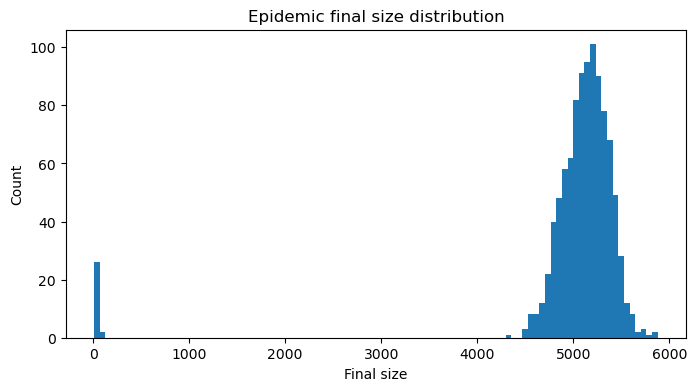

In [5]:
y_S_F=np.dstack(solution_S_F)  # unpack the data
final_size_S_F=y_S_F[-1, 2, :]

plt.figure(figsize=(8, 4))
plt.title("Epidemic final size distribution")
plt.xlabel("Final size")
plt.ylabel("Count")
plt.hist(final_size_S_F, bins=100, color="C0")
plt.show()

We see that 28 of the 1000 simulations (2.8%) have final sizes very close to zero.
In these cases, the chain of infections reaches stochastic extinction before an epidemic is able to take off, as can be seen when plotting a selection of these failed epidemics.

In [ ]:
# Plot failed epidemics
i_success_S_F=np.where(final_size_S_F>2000)
y_fail_S_F=np.delete(y_S_F, obj=i_success_S_F, axis=2) 
f, ax = plt.subplots(figsize=(8, 4))

ax.set_title("Stochastically extinct epidemic trajectories")
ax.set_xlabel("Time")
ax.set_ylabel("Infected count")
for i in range(min(y_fail_S_F.shape[2], 3)):
    ax.plot(t[0:300], y_fail_S_F[0:300,1,i], color="C0", alpha=0.5)


We proceed to eliminate these when plotting our simulation outputs, since we'd like to compare the output here with our deterministic results (which, by definition, do not exhibit stochastic extinction):

In [ ]:
# Delete failed epidemics
i_fail_S_F=np.where(final_size_S_F<2000)
y_success_S_F=np.delete(y_S_F, obj=i_fail_S_F, axis=2) 

#########################
# Individual trajectories
#########################

# Select 50 simulations to plot
i_rand=random.sample(range(y_success_S_F.shape[2]), 50)

######################
# Confidence intervals
######################

# Calculate 95%, 50% CIs and median.
y_S_F_lolo=np.percentile(y_success_S_F, 2.5, axis=2)
y_S_F_lo=np.percentile(y_success_S_F, 25, axis=2)
y_S_F_hi=np.percentile(y_success_S_F, 75, axis=2)
y_S_F_hihi=np.percentile(y_success_S_F, 97.5, axis=2)
y_S_F_md=np.percentile(y_success_S_F, 50, axis=2)


f, axarr = plt.subplots(2,3, layout='constrained', figsize=(10, 5))

# Plot colours
colours=["C1", "C0", "C2"]

for i in range(0,3):
    # Plot individual trajectories
    for j in i_rand:
        axarr[0][i].plot(t, y_success_S_F[:,i,j], color=colours[i], alpha=0.2)

    # Plot CI's
    axarr[1][i].fill_between(t, y_S_F_lolo[:,i], y_S_F_hihi[:,i], alpha=0.2, facecolor=colours[i])
    axarr[1][i].fill_between(t, y_S_F_lo[:,i], y_S_F_hi[:,i], alpha=0.4, facecolor=colours[i])
    axarr[1][i].plot(t, y_S_F_md[:,i], color=colours[i])

# Add titles
for idx, state in enumerate(stateList):
    axarr[0][idx].set_ylabel(state, rotation=0)
    axarr[1][idx].set_ylabel(state, rotation=0)
    axarr[0][idx].set_xlabel('Time')
    axarr[1][idx].set_xlabel('Time')

axarr[0][1].set_title("50 stochastic simulations with shared parameters")
axarr[1][1].set_title("Median (line), 50% CI (dark shaded) and 95% CI (light shaded) over 1000 simulations")

plt.show()

### Random parameters

Finally, we explore a scenario where we wish to solve for a stochastic system with parameters drawn randomly from some distributions.
Using the random parameter set, `random_param_set`, defined previously

In [ ]:
# Set up pygom object
ode_S_R = SimulateOde(stateList, paramList, transition=transitionList)
ode_S_R.initial_values = (x0, t[0])

# In this case n_sim and n_param_draw mean the same thing since we have new parameter set per simulation
ode_S_R.parameters = random_param_set
solution_S_R, simT = ode_S_R.solve_stochast(t, n_sim, full_output=True)

Again, we begin our analysis by inspecting the final size distribution.

In [ ]:
y_S_R=np.dstack(solution_S_R)

final_size_S_R=y_S_R[-1, 2, :]
plt.figure(figsize=(8, 4))
plt.title("Epidemic final size distribution")
plt.xlabel("Final size")
plt.ylabel("Count")
plt.hist(final_size_S_R, bins=100)
plt.show()

We see that the final size distribution is much more spread out, owing to increased variation in the parameters.
The threshold value separating failed and successful epidemics is less clear cut in this case and we judge this by eye to be 2000.
Again, eliminating the failed epidemics we plot the model output

In [ ]:
# Delete failed epidemics
i_fail_S_R=np.where(final_size_S_R<2000)
y_success_S_R=np.delete(y_S_R, obj=i_fail_S_R, axis=2) 

#########################
# Individual trajectories
#########################

# Select 50 simulations to plot
i_rand=random.sample(range(y_success_S_R.shape[2]), 50)

######################
# Confidence intervals
######################

# Calculate 95%, 50% CIs and median.
y_S_R_lolo=np.percentile(y_success_S_R, 2.5, axis=2)
y_S_R_lo=np.percentile(y_success_S_R, 25, axis=2)
y_S_R_hi=np.percentile(y_success_S_R, 75, axis=2)
y_S_R_hihi=np.percentile(y_success_S_R, 97.5, axis=2)
y_S_R_md=np.percentile(y_success_S_R, 50, axis=2)

f, axarr = plt.subplots(2,3, layout='constrained', figsize=(10, 5))

# Plot colours
colours=["C1", "C0", "C2"]

for i in range(0,3):
    # Plot individual trajectories
    for j in i_rand:
        axarr[0][i].plot(t, y_success_S_R[:,i,j], color=colours[i], alpha=0.2)

    # Plot CI's
    axarr[1][i].fill_between(t, y_S_R_lolo[:,i], y_S_R_hihi[:,i], alpha=0.2, facecolor=colours[i])
    axarr[1][i].fill_between(t, y_S_R_lo[:,i], y_S_R_hi[:,i], alpha=0.4, facecolor=colours[i])
    axarr[1][i].plot(t, y_S_R_md[:,i], color=colours[i])

# Add titles
for idx, state in enumerate(stateList):
    axarr[0][idx].set_ylabel(state, rotation=0)
    axarr[1][idx].set_ylabel(state, rotation=0)
    axarr[0][idx].set_xlabel('Time')
    axarr[1][idx].set_xlabel('Time')

axarr[0][1].set_title("50 stochastic simulations, each with randomly drawn parameters")
axarr[1][1].set_title("Median (line), 50% CI (dark shaded) and 95% CI (light shaded) over 1000 simulations")

plt.show()

## Summary

With two possible simulation methods and two possible parameter types, we have explored the four total model configurations.
We plot these results side by side for the infected compartment to provide an illustration of their key qualitative differences.

In [ ]:
ymax=1250

fig, axarr2 = plt.subplots(2,2, layout='constrained', figsize=(10, 6))

axarr2[0][0].plot(t, solution_D_F[:,1], color="C0")
axarr2[0][0].set_ylim(bottom=0, top=ymax)

i_rand=random.sample(range(n_param_draws), 50)

for i in i_rand:
    axarr2[0][1].plot(t, y_S_F[:,1,i], color="C0", alpha=0.3)
    axarr2[1][0].plot(t, y_D_R[:,1,i], color="C0", alpha=0.3)
    axarr2[1][1].plot(t, y_S_R[:,1,i], color="C0", alpha=0.3)

axarr2[0][0].set_title("Deterministic with fixed params")
axarr2[0][1].set_title("Stochastic with fixed params")
axarr2[1][0].set_title("Deterministic with random params")
axarr2[1][1].set_title("Stochastic with random params")

axarr2[0][0].set_xlabel("Time")
axarr2[0][1].set_xlabel("Time")
axarr2[1][0].set_xlabel("Time")
axarr2[1][1].set_xlabel("Time")

axarr2[0][1].set_ylim(bottom=0, top=ymax)
axarr2[1][0].set_ylim(bottom=0, top=ymax)
axarr2[1][1].set_ylim(bottom=0, top=ymax)
plt.show()

<!-- ## Repeatable Simulation

One of the possible uses of compartmental models is to generate
forecasts. Although most of the time the requirement would be to have
(at least point-wise) convergence in the limit, reproducibility is also
important. For both types of interpretation explained above, we have
given the package the capability to repeat the simulations by setting a
seed. When the assumption is that the parameters follows some sort of
distribution, we can set the seed which governs the global state of
the random number generator.




x0 = [2362206.0, 3.0, 0.0]

odeS = SimulateOde(stateList, paramList, transition=transitionList)

d = {'beta': st.gamma(a=100.0, scale=1.0/200.0), 'gamma':st.gamma(a=100.0, scale=1.0/300.0), 'N': x0[0]}

odeS.parameters = d

odeS.initial_values = (x0, t[0])

Ymean, Yall = odeS.simulate_param(t[1::], 10, full_output=True)



np.random.seed(1)

Ymean1, Yall1 = odeS.simulate_param(t[1::], 10, full_output=True)

np.random.seed(1)

Ymean2, Yall2 = odeS.simulate_param(t[1::], 10, full_output=True)

sim_diff = [np.linalg.norm(Yall[i] - yi) for i, yi in enumerate(Yall1)]

sim_diff12 = [np.linalg.norm(Yall2[i] - yi) for i, yi in enumerate(Yall1)]

print("Different in the simulations and the mean: (%s, %s) " %(np.sum(sim_diff), np.sum(np.abs(Ymean1 - Ymean))))

print("Different in the simulations and the mean using same seed: (%s, %s) " % (np.sum(sim_diff12), np.sum(np.abs(Ymean2 - Ymean1))))


In the alternative interpretation, setting the global seed is
insufficient. Unlike simulation based on the parameters, where we can
pre-generate all the parameter values and send them off to individual
processes in the parallel backend, this is prohibitive here. In a
nutshell, the seed does not propagate when using a parallel backend
because each *integration* requires an unknown number of random samples.
Therefore, we have an additional flag **parallel** in the function
signature. By ensuring that the computation runs in serial, we can make
use of the global seed and generate identical runs.


x0 = [2362206.0, 3.0, 0.0]

odeS = SimulateOde(stateList, paramList, transition=transitionList)

odeS.parameters = [0.5, 1.0/3.0, x0[0]]

odeS.initial_values = (x0, t[0])

simX, simT = odeS.simulate_jump(t[1:10], 10, parallel=False, full_output=True)

np.random.seed(1)

simX1, simT1 = odeS.simulate_jump(t[1:10], 10, parallel=False, full_output=True)

np.random.seed(1)

simX2, simT2 = odeS.simulate_jump(t[1:10], 10, parallel=False, full_output=True)

sim_diff = [np.linalg.norm(simX[i] - x1) for i, x1 in enumerate(simX1)]

sim_diff12 = [np.linalg.norm(simX2[i] - x1) for i, x1 in enumerate(simX1)]

print("Difference in simulation: %s" %np.sum(np.abs(sim_diff)))

print("Difference in simulation using same seed: %s" %np.sum(np.abs(sim_diff12))) -->